<a href="https://colab.research.google.com/github/rigonzal/ANN/blob/master/Approach2/Pregunta_1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF-395 Redes Neuronales Artificiales II-2018

## Tarea 2 - Redes Convolucionales y sus aplicaciones


26/11/2018

* Rodrigo González Smith 201303026-2
* Ignacio Valenzuela Albornoz

## Introducción



Débido a la naturaleza del trabajo usaremos **Keras** para la creación de las redes y su posterior entrenamiento/validación. Como también las librerías comunes de trabajo de Python:

In [0]:
#Correr solo en Colab
!pip install -q keras

In [4]:
import numpy as np   
import os   
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
from keras.models import model_from_json
import os
import h5py

%matplotlib inline

Using TensorFlow backend.


## 1. Convolutional Neural Networks (CNN) en CIFAR

Para esta primera parte del informe se trabajaran con los datos de CIFAR10, los cuales correspondes a imágenes las cuales tendremos que clasificar en sus cateogrías correspondientes. De esta manera usaremos CNN, las cuales son adecuadas y efectivas para este tipo de tareas.   

### 1.a) Exploración del Dataset

El data set cuenta con 60.000 imágenes con resolución 32x32, las cuales se clasifican en 10 categorías.  Las proporciones de los datos serán 40.000, 10.000 y 10.000 respectivamente para entrenamiento, validación y test.

In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']  
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Extraemos algunas imágenes para visualizar con sus respectivas etiquetas:

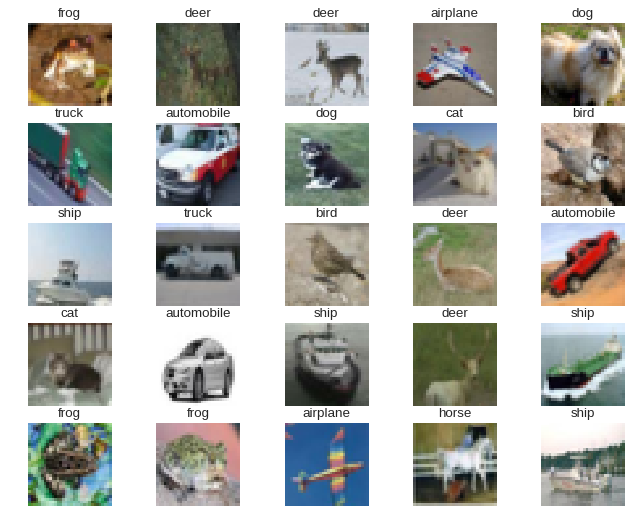

In [6]:
# Aumentamos el tamaño del plot
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

for i in range(25):  
  plt.subplot(5,5,i+1)
  plt.title(label_names[y_train[10*i][0]])
  plt.axis('off')
  _=plt.imshow(x_train[10*i])

La mala resolución se debe a los poco pixeles de la muestra, sin embargo para nuestros fines sera suficiente en el trabajo. Siguiente a esto separamos según como dijimos previamente los datos:

In [7]:
n_train = len(x_train)
x_val = x_train[int(0.8*n_train):n_train]
y_val = y_train[int(0.8*n_train):n_train]
x_train = x_train[:int(0.8*n_train)]
y_train = y_train[:int(0.8*n_train)]

print("Partición del dataset: ")
print("[Training]: " + str(len(x_train)))
print("[Validation]: " + str(len(x_val)))
print("[Test]: " + str(len(x_test)))

Partición del dataset: 
[Training]: 40000
[Validation]: 10000
[Test]: 10000


### 1.b) Preparación de dataset

Normalizamos los datos para que estén en el rango $x \in [0,1]$. En este caso, dado que son positivos al ser RGB. 

In [8]:
x_train_norm = x_train/255
x_val_norm = x_val/255
x_test_norm = x_test/255

num_classes = len(label_names)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Dimensión de cada fila: " + str(x_train_norm[0].shape))

Dimensión de cada fila: (32, 32, 3)


En donde la tercera columna corresponde a la codificación RGB o *channels*.    Por lo cual se estará usando el orden de TensorFlow para el ordenamiento de las dimensiones de las imagenes.

### 1.c) Definición CNN

Se define la red neuronal convolucional inicial a usar para la clasificación.  Se muestra un esquema respecto a la estructura interior de la red, con las dimensiones y sus cambios a medida que se avanza en ella. Notamos que antes de entrar a la capa densa de 512 neurona, se debe hacer un*flatten* del output de la anterior, con tal de que sea un vector de pesos el Input.



In [9]:
model_1_c = Sequential()
model_1_c.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_c.add(Activation('relu'))
model_1_c.add(MaxPooling2D(pool_size=(2, 2)))
model_1_c.add(Conv2D(64, (3, 3), padding='same'))
model_1_c.add(Activation('relu'))
model_1_c.add(MaxPooling2D(pool_size=(2, 2)))
model_1_c.add(Flatten())
model_1_c.add(Dense(512))
model_1_c.add(Activation('relu'))
model_1_c.add(Dense(10))
model_1_c.add(Activation('softmax'))
model_1_c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

### 1.d) Entrenamiento CNN

Para entrenar se usara el algoritmo del gradiente estocástico, con un momentum de 0.9. Además la tasa de apredizaje será cambiada manualmente, y estará en el rango $\eta \in [{10^{-3},10^{-5}}] $.  Esta se reduce a la mitad cada 10 épocas, el entrenamiento inicial se hizo con 25.

In [11]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((epoch)/10))
    lrate = max(lrate,0.00001)
    return lrate
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
batch_size = 1000
epochs = 25
model_1_c.compile(loss="categorical_crossentropy" , optimizer=opt )
history_1_c = model_1_c.fit(x_train_norm, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val_norm,y_val), shuffle=True, callbacks=[lrate])

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 8s 194us/step - loss: 2.2947 - val_loss: 2.2839
Epoch 2/25
40000/40000 [==============================] - 5s 121us/step - loss: 2.2757 - val_loss: 2.2664
Epoch 3/25
40000/40000 [==============================] - 5s 120us/step - loss: 2.2556 - val_loss: 2.2430
Epoch 4/25
40000/40000 [==============================] - 5s 121us/step - loss: 2.2282 - val_loss: 2.2106
Epoch 5/25
40000/40000 [==============================] - 5s 121us/step - loss: 2.1909 - val_loss: 2.1684
Epoch 6/25
40000/40000 [==============================] - 5s 120us/step - loss: 2.1455 - val_loss: 2.1222
Epoch 7/25
40000/40000 [==============================] - 5s 120us/step - loss: 2.0984 - val_loss: 2.0773
Epoch 8/25
40000/40000 [==============================] - 5s 121us/step - loss: 2.0524 - val_loss: 2.0347
Epoch 9/25
40000/40000 [==============================] - 5s 121us/step - loss: 2.0121 - val_loss: 1.9

Con la red ya entrenada, se grafica la perdida de training contra la validación, para de esta manera tener una visión más general de la tendencia en el proceso de entrenamiento:

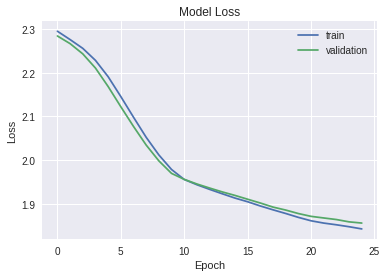

In [12]:
plt.plot(history_1_c.history['loss'])
plt.plot(history_1_c.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Notamos entonces que el error podría haber seguido disminuyendo si se entrenaban algunas épocas más, sin embargo el error en la validación ya estaba mostrando tendencias a separarse. Por lo cual puede que se empezara a "estancar" después de algunas épocas más.

### 1.e)  RMSPop



In [16]:
#se define el modelo
model_1_e = Sequential()
model_1_e.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_e.add(Activation('relu'))
model_1_e.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e.add(Conv2D(64, (3, 3), padding='same'))
model_1_e.add(Activation('relu'))
model_1_e.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e.add(Flatten())
model_1_e.add(Dense(512))
model_1_e.add(Activation('relu'))
model_1_e.add(Dense(10))
model_1_e.add(Activation('softmax'))

#se agrega optimizador
opt = rmsprop(lr=0.001, decay=1e-6)
batch_size = 1000
epochs = 25
model_1_e.compile(loss="categorical_crossentropy" , optimizer=opt )
history_1_e = model_1_e.fit(x_train_norm, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val_norm,y_val), shuffle=True, callbacks=[lrate])

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 5s 137us/step - loss: 2.1282 - val_loss: 1.8520
Epoch 2/25
40000/40000 [==============================] - 5s 123us/step - loss: 1.7509 - val_loss: 1.4827
Epoch 3/25
40000/40000 [==============================] - 5s 123us/step - loss: 1.5536 - val_loss: 1.4118
Epoch 4/25
40000/40000 [==============================] - 5s 122us/step - loss: 1.4373 - val_loss: 1.7434
Epoch 5/25
40000/40000 [==============================] - 5s 122us/step - loss: 1.3345 - val_loss: 1.2894
Epoch 6/25
40000/40000 [==============================] - 5s 122us/step - loss: 1.2384 - val_loss: 1.2305
Epoch 7/25
40000/40000 [==============================] - 5s 123us/step - loss: 1.1821 - val_loss: 1.1756
Epoch 8/25
40000/40000 [==============================] - 5s 123us/step - loss: 1.1163 - val_loss: 1.1351
Epoch 9/25
40000/40000 [==============================] - 5s 122us/step - loss: 1.0655 - val_loss: 1.0

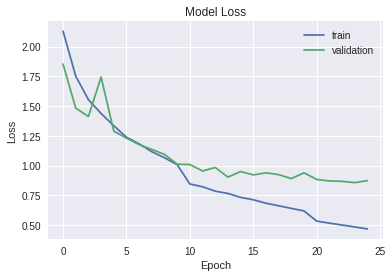

In [17]:
plt.plot(history_1_e.history['loss'])
plt.plot(history_1_e.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()